In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

In [4]:
train_path = 'D:/Data/HAM100000 - Harvard Dataset/preprocessed_data_15split/train'
test_path = 'D:/Data/HAM100000 - Harvard Dataset/preprocessed_data_15split/val'
batch_size = 16 

In [5]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [6]:
image_size = 224
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 53573 images belonging to 7 classes.

Test Batches: 
Found 1494 images belonging to 7 classes.


In [7]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()
 

In [8]:
resnet = tf.keras.applications.ResNet152(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

# Exclude the last 3 layers of the model.
conv = resnet.layers[-23].output

Soft Attention

In [9]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)

In [10]:

output = GlobalAveragePooling2D()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=resnet.input, outputs=output)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block6_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block6_2_relu[0][0]']    
                                                                                                  
 conv3_block6_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block6_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block8_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
          

                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block10_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block10_1_relu[0][0]']   
                                                                                                  
 conv4_block10_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block10_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_2_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block13_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block13_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block13_1_relu[0][0]']   
                                                                                                  
 conv4_block13_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block13_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block13_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block13_2_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block16_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block16_1_relu[0][0]']   
                                                                                                  
 conv4_block16_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block16_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block19_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block19_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block19_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block19_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block19_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block19_1_relu[0][0]']   
                                                                                                  
 conv4_block19_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block19_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block22_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block22_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block22_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block22_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block22_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block22_1_relu[0][0]']   
                                                                                                  
 conv4_block22_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block22_2_conv[0][0]']   
 lization)

 conv4_block25_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block24_out[0][0]']      
                                                                                                  
 conv4_block25_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block25_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block25_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block25_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block28_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block27_out[0][0]']      
                                                                                                  
 conv4_block28_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block28_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block28_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block28_1_relu[0][0]']   
          

                                )                                                                 
                                                                                                  
 conv4_block31_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block30_out[0][0]']      
                                                                                                  
 conv4_block31_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block31_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block31_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block31_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block33_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block33_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block34_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block33_out[0][0]']      
                                                                                                  
 conv4_block34_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block34_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block34_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block34_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block36_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block36_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block36_out[0][0]']      
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)       

In [12]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [13]:
class_weights = {   
                    0: 1.0,  # akiec
                    1: 1.0,  # bcc
                    2: 1.0,  # bkl
                    3: 1.0,  # df
                    4: 5.0,  # mel
                    5: 1.0,  # nv
                    6: 1.0,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath = 'ResNet152+SA.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)




In [14]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=40, min_delta=0.001)
with tf.device('/GPU:0'):
    history = model.fit(train_batches,
#                     steps_per_epoch=(len(train_df)/10),
                    epochs=300,
#                     verbose=2,
                    validation_data=test_batches,
#                     validation_steps=len(test_df)/batch_size,
                    callbacks=[checkpoint,Earlystop],class_weight=class_weights)

Epoch 1/300
3349/3349 [==============================] - 2273s 655ms/step - loss: 3.3238 - accuracy: 0.1806 - val_loss: 1.9037 - val_accuracy: 0.1747
Epoch 2/300
3349/3349 [==============================] - 1330s 397ms/step - loss: 2.0331 - accuracy: 0.3578 - val_loss: 1.3073 - val_accuracy: 0.5154
Epoch 3/300
3349/3349 [==============================] - 1277s 381ms/step - loss: 1.7181 - accuracy: 0.4539 - val_loss: 1.0512 - val_accuracy: 0.6004
Epoch 4/300
3349/3349 [==============================] - 1269s 379ms/step - loss: 1.5456 - accuracy: 0.5120 - val_loss: 1.0235 - val_accuracy: 0.6258
Epoch 5/300
3349/3349 [==============================] - 1175s 351ms/step - loss: 1.3879 - accuracy: 0.5630 - val_loss: 1.0271 - val_accuracy: 0.6218
Epoch 6/300
3349/3349 [==============================] - 1250s 373ms/step - loss: 1.2537 - accuracy: 0.6064 - val_loss: 0.9617 - val_accuracy: 0.6272
Epoch 7/300
3349/3349 [==============================] - 1261s 377ms/step - loss: 1.1505 - accuracy:

3349/3349 [==============================] - 1188s 355ms/step - loss: 0.0383 - accuracy: 0.9893 - val_loss: 1.2326 - val_accuracy: 0.7979
Epoch 56/300
3349/3349 [==============================] - 1300s 388ms/step - loss: 0.0439 - accuracy: 0.9877 - val_loss: 1.2954 - val_accuracy: 0.7858
Epoch 57/300
3349/3349 [==============================] - 1276s 381ms/step - loss: 0.0426 - accuracy: 0.9888 - val_loss: 1.4461 - val_accuracy: 0.7811
Epoch 58/300
3349/3349 [==============================] - 1243s 371ms/step - loss: 0.0301 - accuracy: 0.9919 - val_loss: 1.3527 - val_accuracy: 0.7905
Epoch 59/300
3349/3349 [==============================] - 1240s 370ms/step - loss: 0.0283 - accuracy: 0.9924 - val_loss: 1.2440 - val_accuracy: 0.7938
Epoch 60/300
3349/3349 [==============================] - 1242s 371ms/step - loss: 0.0269 - accuracy: 0.9928 - val_loss: 1.1444 - val_accuracy: 0.7858


In [15]:
from tensorflow.keras import models
model.load_weights("ResNet152+SA.hdf5")

In [16]:
predictions = model.predict(test_batches, 
#                             steps=len(test_df)/batch_size, 
                            verbose=1)

94/94 [==============================] - 30s 273ms/step


In [17]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.66      0.59      0.62        49
         bcc       0.67      0.75      0.71        77
         bkl       0.66      0.58      0.61       164
          df       0.60      0.53      0.56        17
         mel       0.57      0.59      0.58       167
          nv       0.90      0.90      0.90       999
        vasc       0.59      0.76      0.67        21

    accuracy                           0.81      1494
   macro avg       0.66      0.67      0.67      1494
weighted avg       0.81      0.81      0.81      1494



In [18]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.8063925063736407
Recall: 0.8065595716198126
Accuracy: 0.8065595716198126
weighted Roc score: 0.9292350440556919


In [19]:

print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.6637930148812498
Recall: 0.6726260826273694
Accuracy: 0.8065595716198126
Macro Roc score: 0.9452337201988159


In [20]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.8065595716198126
Recall: 0.8065595716198126
Accuracy: 0.8065595716198126
Micro Roc score: 0.9709166130534334


In [21]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9740978744438952
The ROC AUC score of bcc is: 0.9530836136340723
The ROC AUC score of bkl is: 0.9009031725655602
The ROC AUC score of df is: 0.9741526942530567
The ROC AUC score of mel is: 0.9194030928346772
The ROC AUC score of nv is: 0.9299744188633078
The ROC AUC score of vasc is: 0.9650211747971421


In [22]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

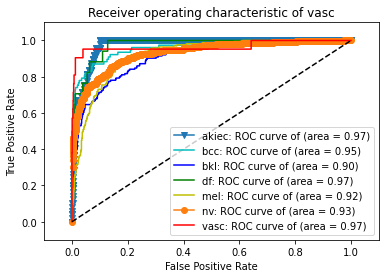

In [23]:

plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()